# Project 3: Natural Language Proccessing
---

**Group C2: Erling Amundsen, Christian Hetling, Alexander Nielsen, Malthe Musaeus, Krzysztof Parocki**

---

In this notebook you will find all our code and methods used for our pdf hand-in. Our focus was on detecting hate speech in tweets in the binary case, and detecting sentiment in tweets in the multi class case. The hate speech tweets and sentiment tweets were taken from the TweetEval corpus - train, test and evaluation data. 
[TweetEval](https://github.com/cardiffnlp/tweeteval#evaluating-your-system)

In [1]:
import collections
import pickle
import re
from collections import Counter
from os.path import exists

import nltk
nltk.download('stopwords')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.lm import WittenBellInterpolated
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.metrics.agreement import AnnotationTask
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
from nltk.util import bigrams, trigrams
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import tokenizer_selfmade
from utils import load_augmented_df, load_to_pd

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kparo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
np.random.seed(17)

## Introduction
---
Natural language models (NLM) are one of the largest sectors in the maching learning community. NLM's are largely used in social media as a tool to stop spreading of misinformation and hatespeech, and in trading bots to evaluate news about stocks. There is a debate on the responsibilites companies have to censor their platforms, and to what extent. Our project focuses solely on correctly labelling tweets from the [TweetEval](https://github.com/cardiffnlp/tweeteval#evaluating-your-system) dataset, and calculates scores only on the basis of the given classification data, not any biases we might have.

## Loading in the datasets
---
The two datasets we have chosen were hate and sentiment.

In [3]:

## Choosing the dataset
dataset1 = 'hate'
dataset2 = 'sentiment'
splits = ['test','train','val']
texts = [dataset1,dataset2]

# Loading the datasets and corresponding labels into panda dataframes
def exporting_data(dataset):
    train_df = load_to_pd('train', dataset)
    val_df = load_to_pd('val', dataset)
    test_df = load_to_pd('test', dataset)

    return train_df, test_df, val_df


train_df_hate, test_df_hate, val_df_hate = exporting_data(dataset1)
train_df_sentiment, test_df_sentiment, val_df_sentiment = exporting_data(dataset2)



In [4]:
## Tokenizing the train_text_df


# Self made tokenizer
train_tokens_hate, unmatchable = tokenizer_selfmade.tokenize_file(f'data/{dataset1}/train_text.txt', unmatch=True)
train_tokens_sentiment, unmatchable = tokenizer_selfmade.tokenize_file(f'data/{dataset2}/train_text.txt', unmatch=True)


# Tweet tokenizer 
tk = TweetTokenizer()
tweet_tokens = train_df_hate['text'].apply(tk.tokenize)


100%|██████████| 9000/9000 [00:03<00:00, 2895.76it/s]
c:\Users\kparo\Desktop\IT Knowledge\First Year Project\Project 3 Natural Language\fyp-2022-nlp\tokenizer_selfmade.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  token_df["tokens"] = np.array(tokens)
100%|██████████| 45615/45615 [00:15<00:00, 2988.06it/s]
c:\Users\kparo\Desktop\IT Knowledge\First Year Project\Project 3 Natural Language\fyp-2022-nlp\tokenizer_selfmade.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  token_df["tokens"] = np.array(tokens)


In [5]:
for our, their in zip(train_tokens_hate['tokens'], tweet_tokens):
    set_our = set(our)
    set_their = set(their)
    diff = set.difference(set_our, set_their)
    if diff:
        print(diff)
        print(f'{" ".join(our)} \n{" ".join(their)} \n')

{'beatlemania', 'are'}
@user nice new signage . are you not concerned by beatlemania - style hysterical crowds crongregating on you … 
@user nice new signage . Are you not concerned by Beatlemania - style hysterical crowds crongregating on you … 

{'hysterical'}
hysterical woman like @user 
Hysterical woman like @user 

{'.', 'so'}
me flirting - so tell me about your father . . . 
Me flirting - So tell me about your father ... 

{'philippine', "bishops'", '.', 'catholic'}
the philippine catholic bishops' work for migrant workers should focus on families who are " paying the great . . . 
The Philippine Catholic bishops ' work for migrant workers should focus on families who are " paying the great ... 

{'sack', 'bf', 'going', 'shit', 'i', 'am', "i'm", 'of', 'ex', 'after', 'not'}
i am not going after your ex bf you lieing sack of shit ! i'm done with you dude that's why i dumped your ass cause your a lieing 😂 😡 bitch 
I AM NOT GOING AFTER YOUR EX BF YOU LIEING SACK OF SHIT ! I'm done wit

In [6]:
print(train_tokens_hate[:10], '\n')
print(tweet_tokens[:10])

                                              tokens
0  [@user, nice, new, signage, ., are, you, not, ...
1  [a, woman, who, you, fucked, multiple, times, ...
2  [@user, @user, real, talk, do, you, have, eyes...
3  [your, girlfriend, lookin, at, me, like, a, gr...
4                   [hysterical, woman, like, @user]
5  [me, flirting, -, so, tell, me, about, your, f...
6  [the, philippine, catholic, bishops', work, fo...
7  [i, am, not, going, after, your, ex, bf, you, ...
8          [when, cuffin, season, is, finally, over]
9  [send, home, migrants, not, in, need, of, prot... 

0    [@user, nice, new, signage, ., Are, you, not, ...
1    [A, woman, who, you, fucked, multiple, times, ...
2    [@user, @user, real, talk, do, you, have, eyes...
3    [your, girlfriend, lookin, at, me, like, a, gr...
4                     [Hysterical, woman, like, @user]
5    [Me, flirting, -, So, tell, me, about, your, f...
6    [The, Philippine, Catholic, bishops, ', work, ...
7    [I, AM, NOT, GOING, AFTER

# Characterizing Data
---

### Data distribution

In this section we calculate the distribution of labels in the datasets as a part of the pre-analysis. It is important for any dataset to have a reasonable representation of all classes, and for the dataset to be large enough. Our datasets are arguably small in size when compared to the massive amount of data that could be attained - millions of tweets, as opposed to thousands. However, it's definitely big enough for our needs.

In [7]:
## calculates the distribution of the labels, the figures are used in the document hand in
texts = [dataset1,dataset2]

sum_list = []
len_list = []


for y in splits:
    _sum = 0
    len_ = 0
    with open(f'data/hate/{y}_labels.txt') as labels:
        for i in labels:
            _sum += int(i)
            len_ += 1
    sum_list.append(_sum)
    len_list.append(len_)
        
print('hate: \n')

for i in range(3):
    print(f'{splits[i]} hate: {sum_list[i]} %: {(sum_list[i]/len_list[i]) * 100 : .3f} \nnon-hate: {len_list[i] - sum_list[i]} %: {(1 - sum_list[i]/len_list[i]) * 100 : .3f} \n')

print('\n')

zero = [0,0,0]
one = [0,0,0]
two = [0,0,0]
len_list2 = [0,0,0]

index = 0
for y in splits:
    with open(f'data/sentiment/{y}_labels.txt') as labels:
        for i in labels:
            if int(i) == 0:
                zero[index] +=1 
            if int(i) == 1:
                one[index] +=1
            if int(i) == 2:
                two[index] += 1
            len_list2[index] += 1
    index += 1

print('sentiemnt:')
for i in range(3):
    print(f'{splits[i]} negative count: {zero[i]} %: {(zero[i]/len_list2[i])*100 : .3f}')
    print(f'{splits[i]} neutral count: {one[i]} %: {(one[i]/len_list2[i])*100 : .3f}')
    print(f'{splits[i]} positive count: {two[i]} %: {(two[i]/len_list2[i])*100 : .3f} \n')

hate: 

test hate: 1252 %:  42.155 
non-hate: 1718 %:  57.845 

train hate: 3783 %:  42.033 
non-hate: 5217 %:  57.967 

val hate: 427 %:  42.700 
non-hate: 573 %:  57.300 



sentiemnt:
test negative count: 3972 %:  32.335
test neutral count: 5937 %:  48.331
test positive count: 2375 %:  19.334 

train negative count: 7093 %:  15.550
train neutral count: 20673 %:  45.321
train positive count: 17849 %:  39.130 

val negative count: 312 %:  15.600
val neutral count: 869 %:  43.450
val positive count: 819 %:  40.950 



If you run the above code, it can be seen that the distribution between hate and non hate is even across the different datasets (train, test, validation). Since it is a binary classification, the distribution is important to adress when it comes to our accuracy scores. With 42% hate distribution, a model that purely guesses hate (or is overly tuned to guess hate) will receive an accuracy score of 42%. Conversely, it would get a 58% score if it guessed only non hate.

In the sentiment dataset the distribution between the test, validation and train seem to differ. The train and validation sets have a similar distribtuion, while the test has a large shift in the negative and positive counts. 

### Token analysis

In [8]:

list_hate_tokens = train_tokens_hate.to_numpy().tolist()
list_sentiment_tokens = train_tokens_sentiment.to_numpy().tolist()

train_list_hate = [i for sublist in list_hate_tokens for item in sublist for i in item]
train_list_sentiment = [i for sublist in list_sentiment_tokens for item in sublist for i in item]


n = 100000
counter_train = Counter(train_list_hate)
counter_sentiment = Counter(train_list_sentiment)
counter_list = [counter_train, counter_sentiment]
for i in range(len(counter_list)):
    one_ = []
    two_ = []
    three_ = [] 
    for key, item in counter_list[i].items():
        if item == 2:
            two_.append((key, item))
        if item == 1:
            one_.append((key, item))
        if item == 3:
            three_.append((key, item))
    print(texts[i], '\n')
    print(counter_list[i].most_common(10), '\n')
    print(one_[:50], '\n')
    print(two_[:50], '\n')
    print(three_[:50], '\n')



hate 

[('.', 9938), ('@user', 6014), ('the', 5506), ('to', 4793), (',', 4489), ('a', 3947), ('you', 3331), ('and', 3229), ('of', 2881), ('in', 2572)] 

[('signage', 1), ('beatlemania', 1), ('crowds', 1), ('crongregating', 1), ('gouged', 1), ('cuffin', 1), ('overstayers', 1), ('hilariously', 1), ('baba', 1), ('royal', 1), ('scribner', 1), ('nebraska', 1), ('temporarily', 1), ('inactive', 1), ('flattered', 1), ('orgasm', 1), ('anatomically', 1), ('bland', 1), ('bulky', 1), ('dej', 1), ('loaf', 1), ('prob', 1), ('nail', 1), ('oportunistic', 1), ('strategic', 1), ('withdrawl', 1), ('lefty', 1), ('miracle', 1), ('knuckle', 1), ('mines', 1), ("irrational'", 1), ('bitters', 1), ("spinsters'", 1), ('dismi', 1), ('injury', 1), ('#getalife', 1), ('#stopspreadinglies', 1), ('fucktard', 1), ('ideas’', 1), ('rosero', 1), ('oral', 1), ('#njhric', 1), ('#newarkpubliclibrary', 1), ('identifying', 1), ('newark', 1), ('injustices', 1), ('wad', 1), ('enrichment’', 1), ('threats’', 1), ('organ', 1)] 

[(

Conclusion: The least frequent words are nouns and proper nouns, which makes sense - they are usually very specific as they describe specific things.

In [9]:
x = Counter(train_list_hate).most_common()[::-1]
print(f"HATE\n\nvocabulary_size: {len(x)}\ncorpus size: {len(train_list_hate)}\ntypes/tokens ratio: {len(x)/len(train_list_hate)}")
y = Counter(train_list_sentiment).most_common()[::-1]
print(f"\nSENTIMENT\n\nvocabulary_size: {len(y)}\ncorpus size: {len(train_list_sentiment)}\ntypes/tokens ratio: {len(y)/len(train_list_sentiment)}")

HATE

vocabulary_size: 18561
corpus size: 215580
types/tokens ratio: 0.0860979682716393

SENTIMENT

vocabulary_size: 47545
corpus size: 1070159
types/tokens ratio: 0.04442797752483509


Differences: The sentiments corpus size is significantly bigger, which produces a better token/type ratio (more tokens are repeated words). However, we didn't notice any major differences with respect to the least frequent tokens. They were still mostly nouns. However, there was a big difference in the numbers of the most frequent nouns due to the corpus size - the Zipf's Law can be seen here in action. 

### Zipfs law

Zipf's law is a phenonoma found in statistics, originating from the relationship of word rank and occurences. In essence, as rank increases, word occurence decreases in a log-like relationship. The following piece of code seeks to visualize this phenomena. It plots the log log plot of the words' ranks at the x axis, and amount of occurences on the y axis to show the inverse relationship between the two, along with a cumulative frequency plot.

In [10]:
def pickle_tokeized_dataset(dataset):
    tok = TreebankWordTokenizer()

    corpus = []
    with open(f'data/{dataset}/train_text.txt', "r") as f:
        corpus.extend(t for line in f for t in tok.tokenize(line))

    with open(f"data/{dataset}-list.pickle", "wb") as f:
        pickle.dump(corpus, f)


def load_pickled_dataset(dataset):
    if not exists(f"data/{dataset}-list.pickle"):
        pickle_tokeized_dataset(dataset)
    with open(f"data/{dataset}-list.pickle", "rb") as f:
        corpus = pickle.load(f)
    return corpus


def plot_zipf_distribution(dataset):
    corpus = load_pickled_dataset(dataset)

    voc = collections.Counter(corpus)
    frq = pd.DataFrame(voc.most_common(), columns=["token", "frequency"])

    # Index in the sorted list
    frq["idx"] = frq.index + 1

    # Frequency normalised by corpus size
    frq["norm_freq"] = frq.frequency / len(corpus)

    # Cumulative normalised frequency
    frq["cumul_frq"] = frq.norm_freq.cumsum()

    seaborn.set_theme(style="whitegrid")

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    fig.suptitle(f"Zipf's Law for tokens in {dataset} dataset", fontsize=16)

    idx = np.array(frq.index.tolist(), dtype='float')

    # Plot: Cumulative frequency by index
    seaborn.scatterplot(ax = axes[0], x=idx, y="cumul_frq", data=frq, edgecolor="none")
    axes[0].set_xlabel("Token Index")
    axes[0].set_ylabel("Cumulative Frequency")
    # Plot: Cumulative frequency by index, top 10000 tokens
    #seaborn.relplot(x="idx", y="cumul_frq", data=frq[:10000], edgecolor="none")
    
    #plt.show()

    # Plot: Log-log plot for Zipf's law
    frq["log(frequency)"] = np.log(frq.frequency)
    frq["log(rank)"] = np.log(frq.frequency.rank(ascending=False))
    seaborn.scatterplot(ax = axes[1], x="log(rank)", y="log(frequency)", data=frq, edgecolor="none", palette= "flare")
    axes[1].set_xlabel("Log Rank")
    axes[1].set_ylabel("Log Frequency")

    plt.tight_layout()
    plt.show()


 hate distributions 



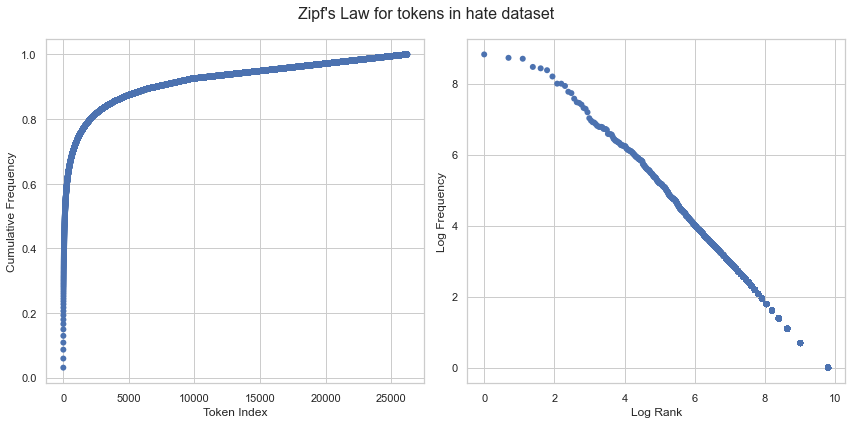


 sentiment distributions 



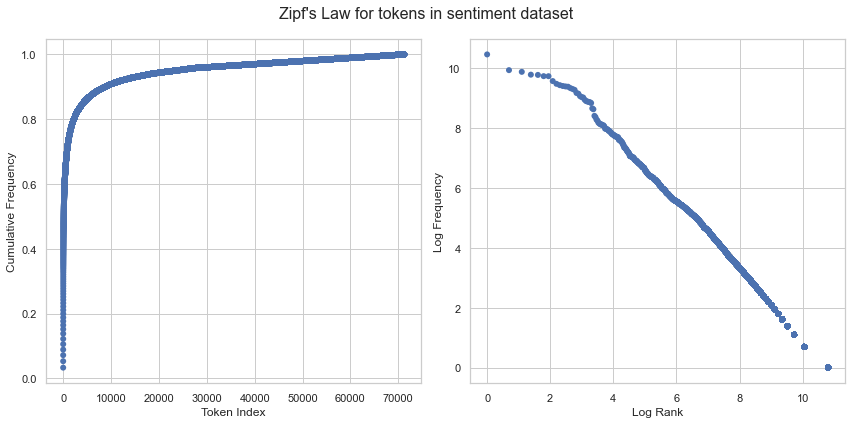

In [11]:
dataset = ['hate', 'sentiment']

for i in dataset:
    print(f'\n {i} distributions \n' )
    plot_zipf_distribution(i)

As can be seen in the plotted graphs, for both corpora follow zipf's law. As rank increases, frequency decreases in a log like relationship.

### Inter Annotator Agreement

In [12]:
# Calculating the Inter-Annotator Agreement (IAA) based on annotated data in data/hate/samples/ folder
import warnings
warnings.filterwarnings("ignore")


In [13]:
# Load in the annotated data for each coder
alex = pd.read_csv('data/hate/samples/alex_annotations.csv', sep='\t')
ea = pd.read_csv('data/hate/samples/EA_eval.csv')
malthe = pd.read_csv('data/hate/samples/malthe_annotations.csv', sep='\t')
christian = pd.read_csv('data/hate/samples/christian_annotations.csv', sep='\t')
krz = pd.read_csv('data/hate/samples/krzysztof_parocki_annotations.csv', sep='\t')
true = pd.read_csv('data/hate/samples/train_text_sample_with_labels.csv', sep='\t')

# Create a new dataframe with only the text column
df = pd.DataFrame(columns=['text'])
df['text'] = alex['text']

# Then add the separate labels from each coder
df['alex'] = alex['label']
df['christian'] = christian['label']
df['krz'] = krz['label']
df['ea'] = ea['label']
df['malthe'] = malthe['label']
df['true'] = true['label']

# Create a new df with the columns [coder, item, label]
new_df = pd.DataFrame(columns=['coder', 'item', 'label'])

# For each unique text in df create a new row in new_df
for index, row in df.iterrows():
    new_df = new_df.append({'coder': 'alex', 'item': row['text'], 'label': row['alex']}, ignore_index=True)
    new_df = new_df.append({'coder': 'christian', 'item': row['text'], 'label': row['christian']}, ignore_index=True)
    new_df = new_df.append({'coder': 'krz', 'item': row['text'], 'label': row['krz']}, ignore_index=True)
    new_df = new_df.append({'coder': 'ea', 'item': row['text'], 'label': row['ea']}, ignore_index=True)
    new_df = new_df.append({'coder': 'malthe', 'item': row['text'], 'label': row['malthe']}, ignore_index=True)

# The format of the data should be: (coder, item, label)
# Turn the new_df into a list of tuples
new_df_list = new_df.values.tolist()
# Turn list of lists into list of tuples
new_df_list = [tuple(x) for x in new_df_list]

for index, row in df.iterrows():
    new_df = new_df.append({'coder': 'true', 'item': row['text'], 'label': row['true']}, ignore_index=True)

all_df_list = new_df.values.tolist()
# Turn list of lists into list of tuples
all_df_list = [tuple(x) for x in all_df_list]

In [14]:
IAA = AnnotationTask(data=new_df_list)
IAA2 = AnnotationTask(data=all_df_list)

print(f"Inter Annotator Agreement (without true labels): {IAA.pi()}")
print(f"Inter Annotator Agreement (with true labels): {IAA2.pi()}")

Inter Annotator Agreement (without true labels): 0.2877105110336816
Inter Annotator Agreement (with true labels): 0.20756480782367945


The Inter Annotator Agreement was quite bad, especially after taking into consideration the actual markings (0.21). Without them, the value is noticeably (0.29) higher. That means we encountered difficulties with understanding guidelines during the annotation task, and we probably should do it again if we want to obtain usable data. However, we decided to use the official labels for the classification task

## Automatic Prediction

We will use Scikit-learn to create a pipeline to preprocess and classify text documents.

In [15]:
# Load in the data:
dataset = 'hate'
df_train = load_to_pd('train', dataset)
df_test = load_to_pd('test', dataset)
df_val = load_to_pd('val', dataset)

# Combine train and test
df_all = pd.concat([df_train, df_test])

Tokenizing step

In [16]:
tk = TweetTokenizer()
porter = PorterStemmer()
english_stopwords = stopwords.words('english')

def preprocess(tweet_text):
    # Lowercase
    tweet_text = tweet_text.lower()

    # Remove punctuation using regex
    tweet_text = re.sub(r'[^\w\s]', '', tweet_text)

    # Remove stopwords from string
    tweet_text = ' '.join([word for word in tweet_text.split() if word not in english_stopwords])

    # Stem the tokens
    stemmed = [porter.stem(word) for word in tweet_text.split(' ')]

    return ' '.join(stemmed)

def tokenize(tweet_text):
    return tk.tokenize(tweet_text)

# Test the above functions
tokenize(preprocess("Hello @user. This is a very LONG test sentence with. and ! ? #maga"))

['hello', 'user', 'long', 'test', 'sentenc', 'maga']

In [17]:
# Create pipeline
pipeline = Pipeline(
    [
        ("vect", CountVectorizer(stop_words=None, preprocessor=preprocess, tokenizer=tokenize)),
        ("tfidf", TfidfTransformer()),
        ("clf", SGDClassifier(random_state = 1)),
    ]
)

In [18]:
# Using grid search to find the optimal parameters for the pipeline components
parameters = {
    'vect__max_df': (0.7, 1.0),
    'vect__min_df': (0, 0.05),
    'vect__max_features': (None, 5000, 10000),
    'tfidf__use_idf': (True, False),
    # 'clf__loss': ('hinge', 'log'), # loss function of sgd classifier
    # 'clf__alpha': (0.00001, 0.0001, 0.001),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=3)
print("Performing grid search...")
grid_search.fit(df_train['text'], df_train['label'])
print("Grid search complete!")
print(f"Best score: {grid_search.best_score_}")
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Performing grid search...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Grid search complete!
Best score: 0.7696666666666666
Best parameters set:
tfidf__use_idf: False
vect__max_df: 0.7
vect__max_features: 10000
vect__min_df: 0


In [19]:
''' 
Below are the best parameters found for the pipeline using the hate dataset:
    Best score: 0.7584444444444445
    Best parameters set:
    clf__alpha: 1e-04
    clf__loss: log
    tfidf__use_idf: False
    vect__max_df: 1.0
    vect__max_features: 10000
    vect__min_df: 0

For the sentiment is is: 
    Best score: 0.6477912967225693
    Best parameters set:
    tfidf__use_idf: True
    vect__max_df: 1.0
    vect__max_features: 10000
    vect__min_df: 0
'''

' \nBelow are the best parameters found for the pipeline using the hate dataset:\n    Best score: 0.7584444444444445\n    Best parameters set:\n    clf__alpha: 1e-04\n    clf__loss: log\n    tfidf__use_idf: False\n    vect__max_df: 1.0\n    vect__max_features: 10000\n    vect__min_df: 0\n\nFor the sentiment is is: \n    Best score: 0.6477912967225693\n    Best parameters set:\n    tfidf__use_idf: True\n    vect__max_df: 1.0\n    vect__max_features: 10000\n    vect__min_df: 0\n'

In [20]:
# A function that takes in a model and outputs the performance
def performance(model, X, y, _dataset='hate'):
    y_pred = model.predict(X)
    if _dataset == 'hate':
        target_names = ['not hate', 'hate']
    elif _dataset == 'sentiment':
        target_names = ['negative', 'neutral', 'positive']
    print(classification_report(y, y_pred, target_names=target_names))
    return model.score(X, y)
    
performance(grid_search, df_val['text'], df_val['label'])

              precision    recall  f1-score   support

    not hate       0.73      0.76      0.75       573
        hate       0.66      0.63      0.65       427

    accuracy                           0.70      1000
   macro avg       0.70      0.70      0.70      1000
weighted avg       0.70      0.70      0.70      1000



0.705

In [21]:
#predicting hate speech

#not hate example
not_hate_string = "This is a test sentence that is not hate."
grid_search.predict([not_hate_string])

#hate example
hate_string = "all immigrants should rot in jail #kill"
grid_search.predict([hate_string])

array([0], dtype=int64)

In [22]:
# Create pipeline for sentiment classification
# Create pipeline
sentiment_pipeline = Pipeline(
    [
        ("vect", CountVectorizer(stop_words=None, preprocessor=preprocess, tokenizer=tokenize, max_features=10000, min_df=0)),
        ("tfidf", TfidfTransformer()),
        ("clf", SGDClassifier(random_state = 1)),
    ]
)

# Fit on sentiment dataset
sentiment_pipeline.fit(train_df_sentiment['text'], train_df_sentiment['label'])

# Report performance
performance(sentiment_pipeline, test_df_sentiment['text'], test_df_sentiment['label'], _dataset='sentiment')


              precision    recall  f1-score   support

    negative       0.78      0.19      0.30      3972
     neutral       0.55      0.85      0.67      5937
    positive       0.54      0.51      0.52      2375

    accuracy                           0.57     12284
   macro avg       0.62      0.51      0.50     12284
weighted avg       0.62      0.57      0.52     12284



0.568625854770433

## Data Augmentation
We chose to augment our data by additional tweets from the offensive dataset, which seemed to contain some good sentences also for task due to similarities to the hate dataset. We tested data augmentation only on the hate prediction.

In [23]:
# Define file paths for 
FILE_PATH_HATE = 'data/hate/train_text.txt'
FILE_PATH_OFFENSIVE = 'data/offensive/train_text.txt'

def tokenize_lines_list(file_path):
    # Helper function to tokenize lines for n-grams
    line_list = []
    with open(file_path, 'r', encoding = 'utf-8') as f:
        lines = f.readlines()

    for line in lines:
        tokens = word_tokenize(line)
        line_list.append(tokens)
    
    return line_list

tokenized_lines = tokenize_lines_list(FILE_PATH_HATE)
tokenized_lines_offensive = tokenize_lines_list(FILE_PATH_OFFENSIVE)
training_data = tokenized_lines
validation_data = tokenized_lines_offensive

all_tokens = []

# for cutoff
one_occurance_tokens = set()

for line in training_data:
    all_tokens.extend(line)

freq_dict = Counter(all_tokens)

for token in freq_dict.keys():
    if freq_dict[token] <= 2:
        one_occurance_tokens.add(token)


print(training_data[0], '\n')

# cutoff = 2 has an effect on perplexity by reducing the number of considered options.
# The removed words get the same prob as new words.

for i, line in enumerate(training_data):
    for j, token in enumerate(line):
        if token in one_occurance_tokens:
            training_data[i][j] = '<UNK>'

print(training_data[0])

#training the model on the distribution after cutoff
train, vocab = padded_everygram_pipeline(3, training_data)

['@', 'user', 'nice', 'new', 'signage', '.', 'Are', 'you', 'not', 'concerned', 'by', 'Beatlemania', '-style', 'hysterical', 'crowds', 'crongregating', 'on', 'you…'] 

['@', 'user', 'nice', 'new', '<UNK>', '.', 'Are', 'you', 'not', 'concerned', 'by', '<UNK>', '<UNK>', 'hysterical', '<UNK>', '<UNK>', 'on', 'you…']


In [24]:
# Create the language model using WittenBell with backoff
# We weren't able to implement KneserNey due to bugs with infinite perplexities
lm = WittenBellInterpolated(3)
lm.fit(train, vocab)

In [25]:
print(lm.score("a"))
print(lm.vocab)
print(lm.counts)
print(lm.generate(40, random_seed=3))

0.013959860630368994
<Vocabulary with cutoff=1 unk_label='<UNK>' and 6306 items>
<NgramCounter with 3 ngram orders and 759111 ngrams>
['<UNK>', 'all', 'kind', 'of', 'negativity', 'in', 'my', 'phone', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>']


In [26]:
validation_data_bigrams = []
validation_data_trigrams = []

for i in validation_data:
    validation_data_bigrams.append(list(bigrams(i)))
    validation_data_trigrams.append(list(trigrams(i)))


print(validation_data_bigrams[0])
print(validation_data_trigrams[0])

[('@', 'user'), ('user', 'Bono'), ('Bono', '...'), ('...', 'who'), ('who', 'cares'), ('cares', '.'), ('.', 'Soon'), ('Soon', 'people'), ('people', 'will'), ('will', 'understand'), ('understand', 'that'), ('that', 'they'), ('they', 'gain'), ('gain', 'nothing'), ('nothing', 'from'), ('from', 'following'), ('following', 'a'), ('a', 'phony'), ('phony', 'celebrity'), ('celebrity', '.'), ('.', 'Become'), ('Become', 'a'), ('a', 'Leader'), ('Leader', 'of'), ('of', 'your'), ('your', 'people'), ('people', 'instead'), ('instead', 'or'), ('or', 'help'), ('help', 'and'), ('and', 'support'), ('support', 'your'), ('your', 'fellow'), ('fellow', 'countrymen'), ('countrymen', '.')]
[('@', 'user', 'Bono'), ('user', 'Bono', '...'), ('Bono', '...', 'who'), ('...', 'who', 'cares'), ('who', 'cares', '.'), ('cares', '.', 'Soon'), ('.', 'Soon', 'people'), ('Soon', 'people', 'will'), ('people', 'will', 'understand'), ('will', 'understand', 'that'), ('understand', 'that', 'they'), ('that', 'they', 'gain'), ('the

In [27]:
# Report bigram perplexity
for line in validation_data_bigrams: 
    if len(line) == 0:
        validation_data_bigrams.remove(line)

print(lm.perplexity(validation_data_bigrams[0]))

# Report the trigram perplexity
for line in validation_data_trigrams: 
    if len(line) == 0:
        validation_data_trigrams.remove(line)

print(lm.perplexity(validation_data_trigrams[0]))

263.6422768829819
444.68856141110336


In [28]:
list_of_perplexity = []

# We will be using trigrams from now on as they provide more context
for line in validation_data_trigrams: 
    list_of_perplexity.append(lm.perplexity(line))

In [29]:
# Report some key statistics
mean_perplexity = np.mean(list_of_perplexity)
median_perplexity = sorted(list_of_perplexity)[len(list_of_perplexity)//2]
mean_perplexity, median_perplexity

(2781.9202368469946, 208.10898264426066)

As the mean is considerably higher than the median, the distribution has to be strongly right-skewed. This is good for us, as we will extract only the left-most sentences with low perplexities

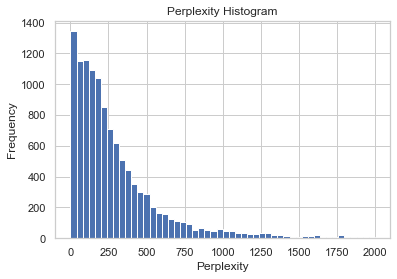

In [30]:
# Create histogram over perplexity
plt.hist(list_of_perplexity, bins = 50, range =(0,2000))
plt.xlabel('Perplexity')
plt.ylabel('Frequency')
plt.title('Perplexity Histogram')
plt.show()


We will take the first quantile as the threshold for self-training sentences. This will add around 4000 sentences to our training set, which is more than 1/3 of the original training set. After looking at the histogram and the mean/median difference, we suspect it will have a positive impact on our model

In [31]:
# Calculate the first quantile
quantile = np.percentile(list_of_perplexity, 25)


# Get the trigram sentences index that have a perplexity below the quantile
quantile_sentences = [index for index, sent in enumerate(validation_data_bigrams) if lm.perplexity(sent) < quantile]
quantile, len(quantile_sentences)

(97.02418779263466, 4375)

In [32]:
# Save the sentences that have a perplexity below the quantile to a file
with open(FILE_PATH_OFFENSIVE, 'r', encoding = 'utf-8') as f:
    lines = f.readlines()

# Save lines to a new file if they have a perplexity below the quantile (trigrams)
with open('data/hate/offensive_sentences_trigram_text.txt', 'w', encoding = 'utf-8') as f:
    for index in quantile_sentences:
        f.write(lines[index])

In [33]:
# Load offensive dataset
df_offensive = load_augmented_df('offensive_sentences_trigram', dataset)

In [34]:
# Generate labels for offensive sentences
df_offensive['label'] = grid_search.predict(df_offensive['text'])

In [35]:
# Print 10 random sentences from the offensive dataset - for insight
df_offensive[df_offensive['label'] == 1].sample(10)

,text,label
1722,@user @user Trump promotes all people. You as ...,1
3627,Get busy... 🤣🤣🤣 #MAGA #ConfirmKavanaugh #Dem...,1
701,@user @user @user @user EVIL @user MUST BE STO...,1
2737,@user @user @user @user Kamala Harris is rapid...,1
3962,Give me a break!! #Unbelievable #liberalloser...,1
3755,We don't need more elitist in government #trum...,1
4278,@user Lmfaoo! 😭 bitch,1
2609,Sorry right wingers 😳😉”Look for a Kaepernick s...,1
1182,@user Becoming..... a woman?,1
3058,@user Wake up black Americans! #maga #Kavanau...,1


In [36]:
# Retrain the model with the offensive dataset

# Concat the offensive dataset with the training dataset
df_all_train = pd.concat([df_train, df_offensive])

model = pipeline.fit(df_all_train['text'], df_all_train['label'])

In [37]:
# Check new performance
performance(model, df_val['text'], df_val['label'])

              precision    recall  f1-score   support

    not hate       0.74      0.78      0.76       573
        hate       0.68      0.62      0.65       427

    accuracy                           0.71      1000
   macro avg       0.71      0.70      0.71      1000
weighted avg       0.71      0.71      0.71      1000



0.715


After adding trigram augmented data the accuracy increased along with the precision and recall metrics. In our case, recall is measured as properly labelled non-hate tweets, and precision as how many of non-hate labellings were correct. Therefore, it would make sense for recall to increase and precision to fall - by using the augmented dataset, we mostly provided our model with more examples of non-hate tweets. This was indeed the case for other random states. However, with this one, the accuracy increased so much that both precision and recall metrics went up. Therefore, we credit this double-increase mostly to hyperparameter (in this case, random state) tuning.